# Recommendation

This notebook shows how to apply [scikit-network](https://scikit-network.readthedocs.io/) for content recommendation. 

We use consider the [Movielens](https://netset.telecom-paris.fr/pages/movielens.html) dataset of the [netset](https://netset.telecom-paris.fr) collection, corresponding to ratings of 9066 movies by 671 users.

In [23]:
from IPython.display import SVG

In [24]:
import numpy as np

In [122]:
from sknetwork.data import load_netset
from sknetwork.ranking import PageRank, top_k
from sknetwork.embedding import Spectral
from sknetwork.utils import WardDense, get_neighbors
from sknetwork.visualization import svg_dendrogram

## Data

In [26]:
dataset = load_netset('movielens')

Parsing files...
Done.


In [27]:
biadjacency = dataset.biadjacency
names = dataset.names
labels = dataset.labels
names_labels = dataset.names_labels

In [29]:
biadjacency

<9066x671 sparse matrix of type '<class 'numpy.float64'>'
	with 100004 stored elements in Compressed Sparse Row format>

In [35]:
n_movies, n_users = biadjacency.shape

In [30]:
# ratings
np.unique(biadjacency.data, return_counts=True)

(array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 array([ 1101,  3326,  1687,  7271,  4449, 20064, 10538, 28750,  7723,
        15095]))

In [33]:
# positive ratings
positive = biadjacency >= 3

In [34]:
positive

<9066x671 sparse matrix of type '<class 'numpy.bool_'>'
	with 82170 stored elements in Compressed Sparse Row format>

In [28]:
names_labels

array(['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'], dtype='<U11')

In [38]:
labels.shape

(9066, 19)

## PageRank

We first use (personalized) PageRank to get the most popular movies of each category.

In [19]:
pagerank = PageRank()

In [52]:
# top-10 movies
scores = pagerank.fit_transform(positive)
names[top_k(scores, 10)]

array(['Forrest Gump (1994)', 'Pulp Fiction (1994)',
       'Shawshank Redemption, The (1994)',
       'Silence of the Lambs, The (1991)',
       'Star Wars: Episode IV - A New Hope (1977)', 'Matrix, The (1999)',
       'Jurassic Park (1993)', "Schindler's List (1993)",
       'Back to the Future (1985)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)'],
      dtype=object)

In [40]:
# number of movies per genre
n_selection = 10

In [41]:
# selection
selection = []
for label in np.arange(len(names_labels)):
    ppr = pagerank.fit_transform(positive, seeds=labels[:, label])
    scores = ppr * labels[:, label]
    selection.append(top_k(scores, n_selection))
selection = np.array(selection)

In [43]:
# show selection (some movies may have several genres)
for label, name_label in enumerate(names_labels):
    print('---')
    print(label, name_label)
    print(names[selection[label, :5]])

---
0 Action
['Star Wars: Episode IV - A New Hope (1977)' 'Matrix, The (1999)'
 'Jurassic Park (1993)'
 'Star Wars: Episode V - The Empire Strikes Back (1980)'
 'Terminator 2: Judgment Day (1991)']
---
1 Adventure
['Star Wars: Episode IV - A New Hope (1977)' 'Jurassic Park (1993)'
 'Star Wars: Episode V - The Empire Strikes Back (1980)'
 'Back to the Future (1985)' 'Toy Story (1995)']
---
2 Animation
['Gnomeo & Juliet (2011)' 'Hop (2011)'
 "Lion King II: Simba's Pride, The (1998)" 'Mars Needs Moms (2011)'
 'Once Upon a Forest (1993)']
---
3 Children
['Spy Kids 3-D: Game Over (2003)' 'Race to Witch Mountain (2009)'
 'G-Force (2009)' 'Prancer (1989)' 'Diary of a Wimpy Kid (2010)']
---
4 Comedy
['Forrest Gump (1994)' 'Pulp Fiction (1994)' 'Back to the Future (1985)'
 'Toy Story (1995)' 'Fargo (1996)']
---
5 Crime
['Pulp Fiction (1994)' 'Shawshank Redemption, The (1994)'
 'Silence of the Lambs, The (1991)' 'Fargo (1996)' 'Godfather, The (1972)']
---
6 Documentary
['Queen of Versailles, The

We now apply PageRank to get the most relevant movies associated with a given movie.

In [77]:
target = {i: name for i, name in enumerate(names) if 'Cherbourg' in name}

In [78]:
target

{175: 'Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964)'}

In [81]:
scores_ppr = pagerank.fit_transform(positive, seeds={175:1})

In [82]:
names[top_k(scores_ppr - scores, 10)]

array(['Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964)',
       'Three Colors: White (Trzy kolory: Bialy) (1994)',
       'Wings of Desire (Himmel über Berlin, Der) (1987)',
       'Three Colors: Red (Trois couleurs: Rouge) (1994)',
       'Like Water for Chocolate (Como agua para chocolate) (1992)',
       'Piano, The (1993)', 'L.A. Confidential (1997)', 'Fargo (1996)',
       'Beauty of the Day (Belle de jour) (1967)',
       'Boot, Das (Boat, The) (1981)'], dtype=object)

We can also apply PageRank to make recommend movies to a user.

In [125]:
user = 1
targets = get_neighbors(positive, user, transpose=True)

In [126]:
# seen movies (sample)
names[targets][:10]

array(['GoldenEye (1995)', 'Sense and Sensibility (1995)',
       'Clueless (1995)', 'Seven (a.k.a. Se7en) (1995)',
       'Usual Suspects, The (1995)', 'Mighty Aphrodite (1995)',
       "Mr. Holland's Opus (1995)", 'Braveheart (1995)',
       'Brothers McMullen, The (1995)', 'Apollo 13 (1995)'], dtype=object)

In [134]:
mask = np.zeros(len(names), dtype=bool)
mask[targets] = 1

In [135]:
scores_ppr = pagerank.fit_transform(positive, seeds=mask)

In [136]:
# top-10 recommendation
names[top_k((scores_ppr - scores) * (1 - mask), 10)]

array(['Shawshank Redemption, The (1994)', 'True Lies (1994)',
       'Star Wars: Episode IV - A New Hope (1977)',
       'Beauty and the Beast (1991)', 'Toy Story (1995)',
       'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 'Fargo (1996)',
       'Independence Day (a.k.a. ID4) (1996)', 'Matrix, The (1999)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)'],
      dtype=object)

## Embedding

We now represent each movie by a vector in low dimension, and use hierarchical clustering to visualize the structure of this embedding for top-100 movies.

In [137]:
# embedding
spectral = Spectral(10)
embedding = spectral.fit_transform(positive)

In [138]:
ward = WardDense()

In [146]:
# top-100 movies
scores = pagerank.fit_transform(positive)
index = top_k(scores, 100)
dendrogram = ward.fit_transform(embedding[index])

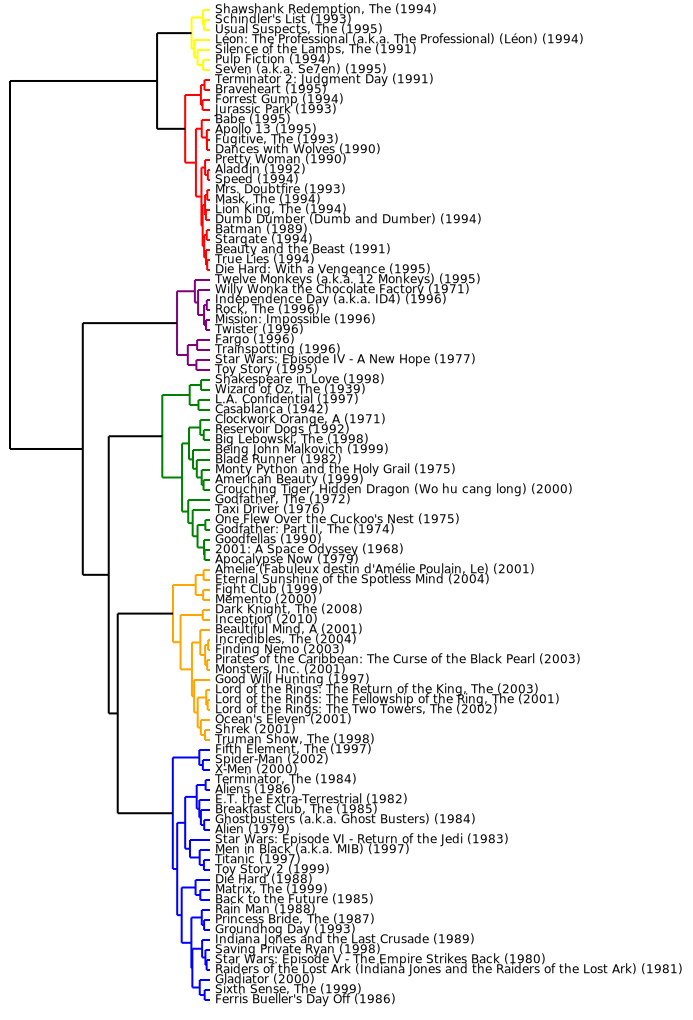

In [149]:
# visualization
image = svg_dendrogram(dendrogram, names=names[index], rotate=True, width=200, height=1000, n_clusters=6)
SVG(image)